### Downloading the Kaggle Dataset using its API.

Installing Kaggle Dependencies

In [1]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [2]:
# Uploading kaggle API key file downloaded
uploaded = files.upload()

Saving kaggle.json to kaggle.json


Moving the kaggle.json file into its designated folder

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

#### Reinstalling Kaggle to make sure, the versions of Kaggle API and Module are compatible.

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=833b33f01cf6e73eab05c89b5ede16ebdeb1cf3c8456e62d44850b9f4db5db6b
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [6]:
#Adjusting the permissions
!chmod 600 /root/.kaggle/kaggle.json

#### Downloading the BRATS 2015 Dataset

In [7]:
!kaggle datasets download -d andrewmvd/brain-tumor-segmentation-in-mri-brats-2015

100% 2.89G/2.90G [00:42<00:00, 106MB/s]
100% 2.90G/2.90G [00:42<00:00, 74.1MB/s]


Extracting the downloaded dataset into a folder

In [8]:
!mkdir BRATS_Dataset
!unzip '/content/brain-tumor-segmentation-in-mri-brats-2015.zip' -d BRATS_Dataset

Archive:  /content/brain-tumor-segmentation-in-mri-brats-2015.zip
  inflating: BRATS_Dataset/License_CC_BY_NC_SA_3.0.txt  
  inflating: BRATS_Dataset/test/HGG_LGG/brats_2013_pat0103_1/VSD.Brain.XX.O.MR_Flair.54193.mha  
  inflating: BRATS_Dataset/test/HGG_LGG/brats_2013_pat0103_1/VSD.Brain.XX.O.MR_T1.54194.mha  
  inflating: BRATS_Dataset/test/HGG_LGG/brats_2013_pat0103_1/VSD.Brain.XX.O.MR_T1c.54195.mha  
  inflating: BRATS_Dataset/test/HGG_LGG/brats_2013_pat0103_1/VSD.Brain.XX.O.MR_T2.54196.mha  
  inflating: BRATS_Dataset/test/HGG_LGG/brats_2013_pat0105_1/VSD.Brain.XX.O.MR_Flair.54199.mha  
  inflating: BRATS_Dataset/test/HGG_LGG/brats_2013_pat0105_1/VSD.Brain.XX.O.MR_T1.54200.mha  
  inflating: BRATS_Dataset/test/HGG_LGG/brats_2013_pat0105_1/VSD.Brain.XX.O.MR_T1c.54201.mha  
  inflating: BRATS_Dataset/test/HGG_LGG/brats_2013_pat0105_1/VSD.Brain.XX.O.MR_T2.54202.mha  
  inflating: BRATS_Dataset/test/HGG_LGG/brats_2013_pat0109_1/VSD.Brain.XX.O.MR_Flair.54205.mha  
  inflating: BRATS_D

In [9]:
#Moving into the Directory to access HGG Training Images
%cd /content/BRATS_Dataset/train

/content/BRATS_Dataset/train


Installing the SimpleITK Plugin

In [15]:
!pip install SimpleITK
import SimpleITK as sitk

     |████████████████████████████████| 42.5MB 73kB/s 


Importing other necessary dependancies

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans
import random as r
#from keras.models import Sequential,load_model,Model,model_from_json
#from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers import Convolution2D,concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
#from keras.layers import Input, merge, UpSampling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K

In [13]:

img_size = 128      #original img size is 240*240
smooth = 1 
num_of_aug = 1
num_epoch = 20

Defining a function augmentation(scans, n) that shall use augmentation techniques to compensate for lack of a big training dataset.

In [10]:
def augmentation(scans,n):          #Rank of input image (scans) must be 4 
    
    #defining an ImageGenerator
    
    datagen = ImageDataGenerator(
        featurewise_center=False,   
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=25,    
        horizontal_flip=True,   
        vertical_flip=True,  
        zoom_range=False)
    
    i=0
    scans_g=scans.copy()
    
    for batch in datagen.flow(scans, batch_size=1, seed=1000):
        i += 1
        if i == n:
            break

    return scans_g

Importing the .mha files from HGG Training Set, and preprocessing them for their use.

In [17]:
import glob
files = glob.glob('HGG/' + '**/*Flair*.mha', recursive=True)

imgs = []   # Processed Images will be stored here
print('Processing---', '**/*Flair*.mha')

for file in files:
    
    img = io.imread(file, plugin='simpleitk')
    img = trans.resize(img, (img_size, img_size, 155), mode='constant')   # Resizing the image into channel_last parameters
    img = (img-img.mean()) / img.std()      # Normalizing the values of pixels, so that they do not diminish or explode   
   
    for slice in range(50,130):
     
        img_t = img[:,:, slice]        # Shape of img_t here is (128,128)
        img_t = img_t.reshape(img_t.shape + (1,))   # Reshaping img_t to (128, 128, 1)
        img_t = img_t.reshape(img_t.shape + (1,))   # Reshaping img_t to (128, 128, 1)
        img_g = augmentation(img_t,num_of_aug)  # Data Augmentation
        
        for n in range(img_g.shape[3]):
            imgs.append(img_g[:,:,:,n])   #Appending them into the final imgs array
            
name = 'x_'+ str(img_size)
np.save(name, np.array(imgs))  # Saving the array

print('Saved', len(files), 'to', name)        

Processing--- **/*Flair*.mha
Saved 220 to x_128


In [18]:
files = glob.glob('HGG/' + '**/*OT*.mha', recursive=True)

imgs = []
print('Processing---', '**/*OT*.mha')

for file in files:
    
    img = io.imread(file, plugin='simpleitk')
    img = trans.resize(img, (img_size,img_size, 155), mode='constant')   # Resizing the image into channel_last parameters
    img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
    img = img.astype('float32')
    
    for slice in range(50,130):
    
        img_t = img[:,:, slice]        # Shape of img_t here is (128,128)
        img_t = img_t.reshape(img_t.shape + (1,))   # Reshaping img_t to (128, 128, 1)
        img_t = img_t.reshape(img_t.shape + (1,))   # Reshaping img_t to (128, 128, 1, 1)
        img_g = augmentation(img_t,num_of_aug)  # Data Augmentation
        
        for n in range(img_g.shape[3]):
            imgs.append(img_g[:,:,:, n])   #Appending them into the final imgs array

name = 'y_'+ str(img_size)
np.save(name, np.array(imgs))  # Saving the data

print('Saved', len(files), 'to', name)

Processing--- **/*OT*.mha
Saved 220 to y_128


In [22]:

def n4itk(img):         #must input with sitk img object
    img = sitk.Cast(sitk.sitkFloat32, img)
    img_mask = sitk.BinaryNot(sitk.BinaryThreshold(0, 0, img))   ## Create a mask spanning the part containing the brain, as we want to apply the filter to the brain image
    corrected_img = sitk.N4BiasFieldCorrection(img_mask, img)
    return corrected_img    


Defining Dice Coefficient Loss

In [19]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Installing a U-Net Library that can be used to form a custom U-Net

In [20]:
!pip install keras-unet

In [21]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(img_size, img_size, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid')

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


![alt text](https://raw.githubusercontent.com/karolzak/keras-unet/master/docs/custom_unet.png)

In [22]:
x = np.load('x_{}.npy'.format(img_size))
y = np.load('y_{}.npy'.format(img_size))

In [23]:
opt = Adam(lr=0.00001)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef])

In [24]:
history = model.fit(x, y, batch_size = 16, validation_split = 0.2, verbose=1, epochs = 20, shuffle=True)

Epoch 1/20
880/880 [==============================] - 109s 124ms/step - loss: -0.2076 - dice_coef: 0.2076 - val_loss: -0.1156 - val_dice_coef: 0.1156
Epoch 2/20
880/880 [==============================] - 108s 123ms/step - loss: -0.2996 - dice_coef: 0.2996 - val_loss: -0.1403 - val_dice_coef: 0.1403
Epoch 3/20
880/880 [==============================] - 108s 122ms/step - loss: -0.3930 - dice_coef: 0.3930 - val_loss: -0.1663 - val_dice_coef: 0.1663
Epoch 4/20
880/880 [==============================] - 108s 122ms/step - loss: -0.4665 - dice_coef: 0.4665 - val_loss: -0.2428 - val_dice_coef: 0.2428
Epoch 5/20
880/880 [==============================] - 108s 122ms/step - loss: -0.5245 - dice_coef: 0.5245 - val_loss: -0.2203 - val_dice_coef: 0.2203
Epoch 6/20
880/880 [==============================] - 108s 122ms/step - loss: -0.5759 - dice_coef: 0.5759 - val_loss: -0.2454 - val_dice_coef: 0.2454
Epoch 7/20
880/880 [==============================] - 108s 122ms/step - loss: -0.6064 - dice_coef: 0

In [25]:
#Saving the Model and its weights
model.save('aug{}_{}_epoch{}'.format(num_of_aug,img_size,num_epoch))
model.save_weights('weights_{}_{}.h5'.format(img_size,num_epoch))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: aug1_128_epoch20/assets


dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])


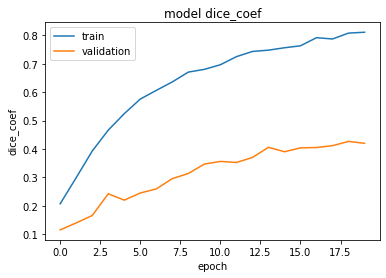

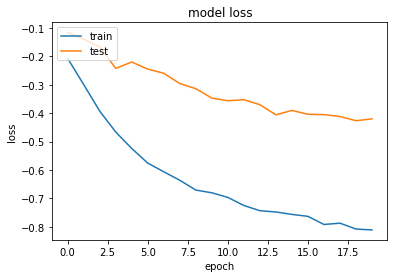

In [26]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We next use the model to predict outputs for a given image set

In [27]:
pred = model.predict(x[1000:1100])

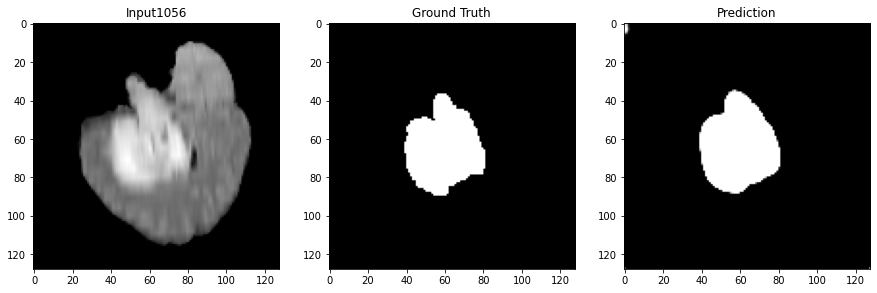

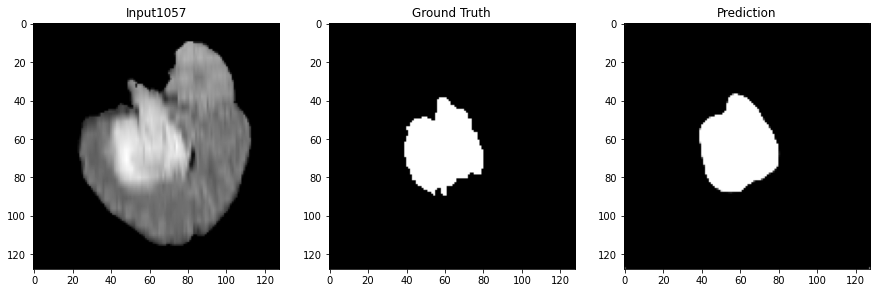

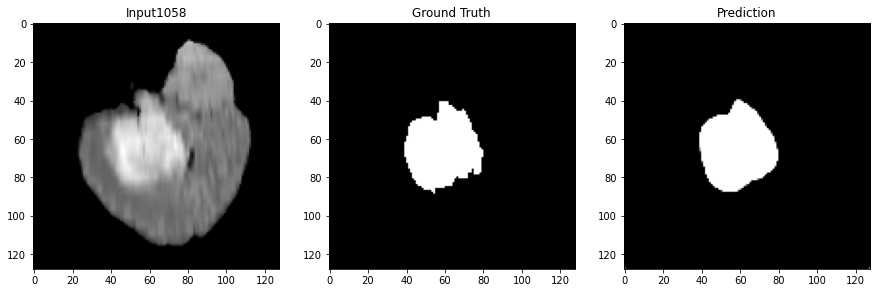

In [28]:
for n in range(3):
    i = 56+n
    plt.figure(figsize=(15,10))

    plt.subplot(131)
    plt.title('Input'+str(i+1000))
    plt.imshow(x[i+1000, :, :, 0],cmap='gray')

    plt.subplot(132)
    plt.title('Ground Truth')
    plt.imshow(y[i+1000, :, :, 0],cmap='gray')

    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(pred[i, :, :, 0],cmap='gray')

    plt.show()